# G2M Case Study Notebook

Erik Pérez

perez.erik@pucp.edu.pe

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import os
import seaborn as sns
import datetime
from scipy import stats

## Extract data

In [9]:
# Filenames: Cab_Data, City, Customer_ID, Transaction_ID, US_Bank_holidays

MainPath = os.path.abspath(os.path.dirname('__file__')) #  os.path.dirname(os.path.realpath('__file__'))
data_dictionary = {} #Dictionary to store the dataframes
for filename in os.listdir(MainPath): # Loop over the binder
    if '.csv' in filename: # Condition to open .csv file
        name = filename.split('.')[0] # Extract name of file
        data_dictionary[name] = pd.read_csv(filename) # Save each dataframe with the respective key as the filename

In [10]:
cab_df = data_dictionary['Cab_Data'].copy()
city_df = data_dictionary['City'].copy()
customer_df = data_dictionary['Customer_ID'].copy()
transaction_df = data_dictionary['Transaction_ID'].copy()
holiday_df = data_dictionary['US_Bank_holidays'].copy()

Explore the data 

In [11]:
cab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 7 columns):
Transaction ID    359392 non-null int64
Date of Travel    359392 non-null int64
Company           359392 non-null object
City              359392 non-null object
KM Travelled      359392 non-null float64
Price Charged     359392 non-null float64
Cost of Trip      359392 non-null float64
dtypes: float64(3), int64(2), object(2)
memory usage: 19.2+ MB


In [12]:
city_df

,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"
5,ORANGE COUNTY,"1,030,185","12,994"
6,SAN DIEGO CA,"959,307","69,995"
7,PHOENIX AZ,"943,999","6,133"
8,DALLAS TX,"942,908","22,157"
9,ATLANTA GA,"814,885","24,701"


In [13]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49171 entries, 0 to 49170
Data columns (total 4 columns):
Customer ID           49171 non-null int64
Gender                49171 non-null object
Age                   49171 non-null int64
Income (USD/Month)    49171 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [14]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440098 entries, 0 to 440097
Data columns (total 3 columns):
Transaction ID    440098 non-null int64
Customer ID       440098 non-null int64
Payment_Mode      440098 non-null object
dtypes: int64(2), object(1)
memory usage: 10.1+ MB


In [15]:
holiday_df

,1,2012-01-02,New Year Day
0,2,2012-01-16,Martin Luther King Jr. Day
1,3,2012-02-20,Presidents Day (Washingtons Birthday)
2,4,2012-05-28,Memorial Day
3,5,2012-07-04,Independence Day
4,6,2012-09-03,Labor Day
...,...,...,...
84,86,2020-09-07,Labor Day
85,87,2020-10-12,Columbus Day
86,88,2020-11-11,Veterans Day
87,89,2020-11-26,Thanksgiving Day


## Data organization:

### Study the 5 files and determine the relationship between files, construct new important and relevant features and parameters for the subsequent analysis. Construct a mayor dataframe with all the important information and the ordered by transactions.

Filter the Transaction ID and consider only the ones that are in dataset Cab_Data. Then include the Customer ID, number of transactions, age, income, and gender.

Consider 2 dataframes: First one with the Customer ID (Eliminate repeated), Age, Gender, Payment Mode (col1 Cash, col2 Card), income and Number of Transactions. 

In [16]:
transaction_df.sort_values(by=['Customer ID'],inplace=True) # Sort by customer ID
customer_df.sort_values(by=['Customer ID'],inplace=True) # Sort Customers df by customers ID

In [17]:
customer_df.head()

,Customer ID,Gender,Age,Income (USD/Month)
7098,1,Male,36,16359
8267,2,Male,31,12069
9331,3,Female,27,12968
3511,4,Male,33,13803
10897,5,Male,24,9965


In [18]:
transaction_df.head()

,Transaction ID,Customer ID,Payment_Mode
292523,10292534,1,Card
241354,10241365,1,Cash
74079,10074090,1,Cash
251185,10251196,1,Card
8423,10008434,1,Cash


Each customer has 'X' transactions. So we union both dataframes (Transactions and Customers) into one dataframe to have information of the transactions of each customer, payment mode, gender, age and income. Some values will be repeated because the customers have repeated transactions.

In [19]:
transaction_df2 = pd.merge(transaction_df,customer_df)
transaction_df2.head()

,Transaction ID,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
0,10292534,1,Card,Male,36,16359
1,10241365,1,Cash,Male,36,16359
2,10074090,1,Cash,Male,36,16359
3,10251196,1,Card,Male,36,16359
4,10008434,1,Cash,Male,36,16359


All the transactions made are not registered by the companies. We can observe that from the dimensions of the dataframes. There are less transactions in the Cab_Data csv, this means that we will not need all the transactions and customers identifications, only the ones that are registered by the companies. We have to verify first that indeed all the transactions registered by the cab companies are included in the transactions dataframe.

In [20]:
transaction1 = transaction_df2['Transaction ID'].values
transaction2 = cab_df['Transaction ID'].values
print(transaction1.shape)
print(transaction2.shape)

(440098,)
(359392,)


In [21]:
# Define a function to determine if all of the transactions of cab_df are included in transaction_df

def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

In [22]:
intersect = intersection(transaction2,transaction1)
all(intersect==transaction2) # We verify if all the transactions in cab_data are included in transaction_df

True

In [23]:
# Next we merge cab_df and transaction_df. In this new dataframe we will have only the relevant transactions that are
# linked with the companies. The rest of transactions will not be considered in the subsequent analysis because we
# dont have more relevant information such as date of travel, price, cost, city, etc.
Main_df = pd.merge(cab_df,transaction_df2)
Main_df

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card,Male,27,9237
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.6320,28712,Cash,Male,53,11242
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.6020,28020,Cash,Male,23,23327
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.7760,27182,Card,Male,33,8536
...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10440101,43108,Yellow Cab,WASHINGTON DC,4.80,69.24,63.3600,52392,Cash,Male,24,15651
359388,10440104,43104,Yellow Cab,WASHINGTON DC,8.40,113.75,106.8480,53286,Cash,Male,32,6528
359389,10440105,43105,Yellow Cab,WASHINGTON DC,27.75,437.07,349.6500,52265,Cash,Male,56,7966
359390,10440106,43105,Yellow Cab,WASHINGTON DC,8.80,146.19,114.0480,52175,Card,Male,32,6423


We create a 3 new features: Number of transactions for each customer, number of cash transactions, number of card transactions

In [24]:
# Create 2 columns Card and Cash 
# In each transaction if the transaction was Card: write 1 in Card and 0 in Cash 
                    # if the transaction was Cash: write 1 in Cash and 0 in Card

Main_df_aux = Main_df.copy() # Create auxiliary dataframe to modify columns

for index, row in Main_df.iterrows():
    # Iterate over the rows
    pay_mode = row['Payment_Mode'] # Search for payment mode: Cash or Card
    Main_df_aux.at[index,pay_mode] = 1 # Enter number 1 
Main_df_aux.fillna(0,inplace=True) # Nan values fill with 0
Main_df_aux.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Card,Cash
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.635,29290,Card,Male,28,10813,1.0,0.0
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.854,27703,Card,Male,27,9237,1.0,0.0
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.632,28712,Cash,Male,53,11242,0.0,1.0
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.602,28020,Cash,Male,23,23327,0.0,1.0
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.776,27182,Card,Male,33,8536,1.0,0.0


In [25]:
# Create dataframe with number of payments by card or cash for each customer
Card_Cash_df = Main_df_aux.groupby('Customer ID', sort=True, as_index=False)[['Card','Cash']].sum()

# Create column with number of transactions for each customer :
Card_Cash_df ['Total Transactions'] = Card_Cash_df ['Card']+Card_Cash_df ['Cash']

Card_Cash_df.head()

,Customer ID,Card,Cash,Total Transactions
0,1,18.0,11.0,29.0
1,2,25.0,15.0,40.0
2,3,30.0,16.0,46.0
3,4,17.0,9.0,26.0
4,5,20.0,11.0,31.0


### Master Dataframe

In [26]:
Main_df2 = pd.merge(Main_df,Card_Cash_df) # Merge Main_df and the number of transaction df
Main_df2.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Card,Cash,Total Transactions
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813,2.0,1.0,3.0
1,10351127,43302,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,29290,Cash,Male,28,10813,2.0,1.0,3.0
2,10412921,43427,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,29290,Card,Male,28,10813,2.0,1.0,3.0
3,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card,Male,27,9237,3.0,1.0,4.0
4,10320494,43211,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,27703,Card,Male,27,9237,3.0,1.0,4.0


## Analysis 1: Profit and Time Analysis 

### We perform an analysis of the profit by year, month, city and the rentable profit (profit with price charged > cost of trip).

Analyze the profit of each cab company yearly, profit per km, total of rides, profit per rides

In [27]:
Main_df2.sort_values( by = ['Date of Travel','Transaction ID'],inplace=True) # Sort by date of travel and Transaction ID
Main_df2.reset_index(drop=True,inplace=True) # Drop old index
Main_df2

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Card,Cash,Total Transactions
0,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.6320,28712,Cash,Male,53,11242,2.0,2.0,4.0
1,10000029,42371,Pink Cab,BOSTON MA,21.34,324.21,226.2040,58925,Card,Male,38,26550,6.0,2.0,8.0
2,10000030,42371,Pink Cab,BOSTON MA,41.30,646.06,454.3000,58551,Card,Male,25,21734,7.0,4.0,11.0
3,10000041,42371,Pink Cab,CHICAGO IL,35.02,598.43,406.2320,4289,Card,Male,19,28719,11.0,9.0,20.0
4,10000045,42371,Pink Cab,CHICAGO IL,3.24,48.04,33.6960,5734,Card,Male,23,22475,8.0,8.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10439960,43465,Yellow Cab,WASHINGTON DC,33.93,474.47,411.2316,52449,Card,Female,40,23569,9.0,3.0,12.0
359388,10439984,43465,Yellow Cab,WASHINGTON DC,40.00,641.78,484.8000,51614,Card,Female,55,12279,7.0,8.0,15.0
359389,10440028,43465,Yellow Cab,WASHINGTON DC,26.22,405.25,327.2256,52389,Card,Female,29,5568,8.0,5.0,13.0
359390,10440034,43465,Yellow Cab,WASHINGTON DC,34.68,505.38,470.2608,51877,Cash,Male,46,16993,10.0,5.0,15.0


Column: Profit of each transaction ID. NOTE: Negative profits represent losses\
Column: Profit per KM

In [28]:
Main_df2['Profit'] = Main_df2['Price Charged'] - Main_df2['Cost of Trip'] # Define Profit
Main_df2['Profit per KM'] = Main_df2['Profit']/Main_df2['KM Travelled'] # Define profit per km
Main_df2.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Card,Cash,Total Transactions,Profit,Profit per KM
0,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.632,28712,Cash,Male,53,11242,2.0,2.0,4.0,27.568,3.049558
1,10000029,42371,Pink Cab,BOSTON MA,21.34,324.21,226.204,58925,Card,Male,38,26550,6.0,2.0,8.0,98.006,4.592596
2,10000030,42371,Pink Cab,BOSTON MA,41.30,646.06,454.300,58551,Card,Male,25,21734,7.0,4.0,11.0,191.760,4.643099
3,10000041,42371,Pink Cab,CHICAGO IL,35.02,598.43,406.232,4289,Card,Male,19,28719,11.0,9.0,20.0,192.198,5.488235
4,10000045,42371,Pink Cab,CHICAGO IL,3.24,48.04,33.696,5734,Card,Male,23,22475,8.0,8.0,16.0,14.344,4.427160


Change Date of Travel to real dates:

In [29]:
min_num = Main_df2['Date of Travel'].min() # min date
Main_df2['Date of Travel'] = Main_df2['Date of Travel'] - min_num  # Start date from 0 to 1094
Main_df2

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Card,Cash,Total Transactions,Profit,Profit per KM
0,10000013,0,Pink Cab,ATLANTA GA,9.04,125.20,97.6320,28712,Cash,Male,53,11242,2.0,2.0,4.0,27.5680,3.049558
1,10000029,0,Pink Cab,BOSTON MA,21.34,324.21,226.2040,58925,Card,Male,38,26550,6.0,2.0,8.0,98.0060,4.592596
2,10000030,0,Pink Cab,BOSTON MA,41.30,646.06,454.3000,58551,Card,Male,25,21734,7.0,4.0,11.0,191.7600,4.643099
3,10000041,0,Pink Cab,CHICAGO IL,35.02,598.43,406.2320,4289,Card,Male,19,28719,11.0,9.0,20.0,192.1980,5.488235
4,10000045,0,Pink Cab,CHICAGO IL,3.24,48.04,33.6960,5734,Card,Male,23,22475,8.0,8.0,16.0,14.3440,4.427160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10439960,1094,Yellow Cab,WASHINGTON DC,33.93,474.47,411.2316,52449,Card,Female,40,23569,9.0,3.0,12.0,63.2384,1.863790
359388,10439984,1094,Yellow Cab,WASHINGTON DC,40.00,641.78,484.8000,51614,Card,Female,55,12279,7.0,8.0,15.0,156.9800,3.924500
359389,10440028,1094,Yellow Cab,WASHINGTON DC,26.22,405.25,327.2256,52389,Card,Female,29,5568,8.0,5.0,13.0,78.0244,2.975759
359390,10440034,1094,Yellow Cab,WASHINGTON DC,34.68,505.38,470.2608,51877,Cash,Male,46,16993,10.0,5.0,15.0,35.1192,1.012664


In [30]:
day1 = datetime.date(2016,1,1) # First day of 2016
day1 = pd.Timestamp(day1) # Creat Timestamp
deltas = pd.to_timedelta(Main_df2['Date of Travel'],unit='D') # Change values to days format
days_format = day1+deltas # Add delta days to the initial day 
Main_df2['Date of Travel'] = pd.Series(pd.DatetimeIndex(days_format).year) # Create column of years(Only relevant information)
Main_df2['Month'] = pd.Series(pd.DatetimeIndex(days_format).month) # Month from jan to dec
Main_df2['Day'] = pd.Series(pd.DatetimeIndex(days_format).day) # Days from 1 to 30
Main_df2['Day of Week'] = pd.Series(pd.DatetimeIndex(days_format).dayofweek) # Day of week from 0 to 6
Main_df2['Week'] = pd.Series(pd.DatetimeIndex(days_format).week) # Week of year 1 to 52 or 53
Main_df2

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,...,Income (USD/Month),Card,Cash,Total Transactions,Profit,Profit per KM,Month,Day,Day of Week,Week
0,10000013,2016,Pink Cab,ATLANTA GA,9.04,125.20,97.6320,28712,Cash,Male,...,11242,2.0,2.0,4.0,27.5680,3.049558,1,1,4,53
1,10000029,2016,Pink Cab,BOSTON MA,21.34,324.21,226.2040,58925,Card,Male,...,26550,6.0,2.0,8.0,98.0060,4.592596,1,1,4,53
2,10000030,2016,Pink Cab,BOSTON MA,41.30,646.06,454.3000,58551,Card,Male,...,21734,7.0,4.0,11.0,191.7600,4.643099,1,1,4,53
3,10000041,2016,Pink Cab,CHICAGO IL,35.02,598.43,406.2320,4289,Card,Male,...,28719,11.0,9.0,20.0,192.1980,5.488235,1,1,4,53
4,10000045,2016,Pink Cab,CHICAGO IL,3.24,48.04,33.6960,5734,Card,Male,...,22475,8.0,8.0,16.0,14.3440,4.427160,1,1,4,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10439960,2018,Yellow Cab,WASHINGTON DC,33.93,474.47,411.2316,52449,Card,Female,...,23569,9.0,3.0,12.0,63.2384,1.863790,12,30,6,52
359388,10439984,2018,Yellow Cab,WASHINGTON DC,40.00,641.78,484.8000,51614,Card,Female,...,12279,7.0,8.0,15.0,156.9800,3.924500,12,30,6,52
359389,10440028,2018,Yellow Cab,WASHINGTON DC,26.22,405.25,327.2256,52389,Card,Female,...,5568,8.0,5.0,13.0,78.0244,2.975759,12,30,6,52
359390,10440034,2018,Yellow Cab,WASHINGTON DC,34.68,505.38,470.2608,51877,Cash,Male,...,16993,10.0,5.0,15.0,35.1192,1.012664,12,30,6,52


In [31]:

Main_df2

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,...,Income (USD/Month),Card,Cash,Total Transactions,Profit,Profit per KM,Month,Day,Day of Week,Week
0,10000013,2016,Pink Cab,ATLANTA GA,9.04,125.20,97.6320,28712,Cash,Male,...,11242,2.0,2.0,4.0,27.5680,3.049558,1,1,4,53
1,10000029,2016,Pink Cab,BOSTON MA,21.34,324.21,226.2040,58925,Card,Male,...,26550,6.0,2.0,8.0,98.0060,4.592596,1,1,4,53
2,10000030,2016,Pink Cab,BOSTON MA,41.30,646.06,454.3000,58551,Card,Male,...,21734,7.0,4.0,11.0,191.7600,4.643099,1,1,4,53
3,10000041,2016,Pink Cab,CHICAGO IL,35.02,598.43,406.2320,4289,Card,Male,...,28719,11.0,9.0,20.0,192.1980,5.488235,1,1,4,53
4,10000045,2016,Pink Cab,CHICAGO IL,3.24,48.04,33.6960,5734,Card,Male,...,22475,8.0,8.0,16.0,14.3440,4.427160,1,1,4,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10439960,2018,Yellow Cab,WASHINGTON DC,33.93,474.47,411.2316,52449,Card,Female,...,23569,9.0,3.0,12.0,63.2384,1.863790,12,30,6,52
359388,10439984,2018,Yellow Cab,WASHINGTON DC,40.00,641.78,484.8000,51614,Card,Female,...,12279,7.0,8.0,15.0,156.9800,3.924500,12,30,6,52
359389,10440028,2018,Yellow Cab,WASHINGTON DC,26.22,405.25,327.2256,52389,Card,Female,...,5568,8.0,5.0,13.0,78.0244,2.975759,12,30,6,52
359390,10440034,2018,Yellow Cab,WASHINGTON DC,34.68,505.38,470.2608,51877,Cash,Male,...,16993,10.0,5.0,15.0,35.1192,1.012664,12,30,6,52


In [32]:
pd.DatetimeIndex(days_format)

DatetimeIndex(['2016-01-01', '2016-01-01', '2016-01-01', '2016-01-01',
               '2016-01-01', '2016-01-01', '2016-01-01', '2016-01-01',
               '2016-01-01', '2016-01-01',
               ...
               '2018-12-30', '2018-12-30', '2018-12-30', '2018-12-30',
               '2018-12-30', '2018-12-30', '2018-12-30', '2018-12-30',
               '2018-12-30', '2018-12-30'],
              dtype='datetime64[ns]', name='Date of Travel', length=359392, freq=None)

In [33]:
# Reorder the columns:
cols_order = ['Transaction ID','Date of Travel','Day','Day of Week','Week','Month','Company','City','KM Travelled','Price Charged','Cost of Trip',
             'Profit','Profit per KM','Customer ID','Payment_Mode','Gender','Age','Income (USD/Month)','Card',
              'Cash','Total Transactions']

Main_df2 = Main_df2[cols_order]
Main_df2.head()

,Transaction ID,Date of Travel,Day,Day of Week,Week,Month,Company,City,KM Travelled,Price Charged,...,Profit,Profit per KM,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Card,Cash,Total Transactions
0,10000013,2016,1,4,53,1,Pink Cab,ATLANTA GA,9.04,125.20,...,27.568,3.049558,28712,Cash,Male,53,11242,2.0,2.0,4.0
1,10000029,2016,1,4,53,1,Pink Cab,BOSTON MA,21.34,324.21,...,98.006,4.592596,58925,Card,Male,38,26550,6.0,2.0,8.0
2,10000030,2016,1,4,53,1,Pink Cab,BOSTON MA,41.30,646.06,...,191.760,4.643099,58551,Card,Male,25,21734,7.0,4.0,11.0
3,10000041,2016,1,4,53,1,Pink Cab,CHICAGO IL,35.02,598.43,...,192.198,5.488235,4289,Card,Male,19,28719,11.0,9.0,20.0
4,10000045,2016,1,4,53,1,Pink Cab,CHICAGO IL,3.24,48.04,...,14.344,4.427160,5734,Card,Male,23,22475,8.0,8.0,16.0


Determine the average profit per km of both companies yearly

In [34]:
Profit_Av_Per_km = Main_df2.groupby(['Date of Travel','Company'])['Profit per KM'].mean() # Average profit per date per 
                                                                                        # per company per km

ProfitKm_df = pd.DataFrame({'Prof/Km':Profit_Av_Per_km}).reset_index()
ProfitKm_df

,Date of Travel,Company,Prof/Km
0,2016,Pink Cab,3.045984
1,2016,Yellow Cab,7.505961
2,2017,Pink Cab,2.948888
3,2017,Yellow Cab,7.476486
4,2018,Pink Cab,2.346011
5,2018,Yellow Cab,6.366253


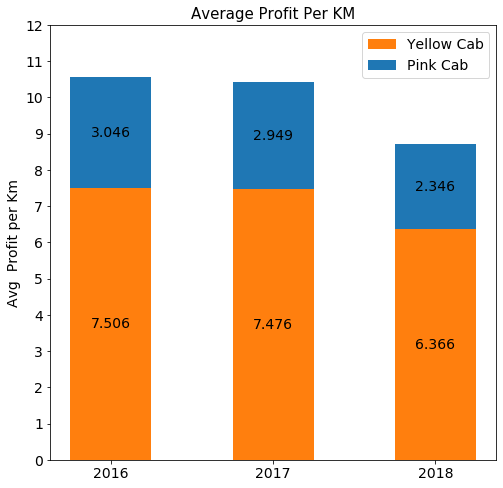

In [35]:
N = 3

years = ['2016','2017','2018']

YellowVals = [row[2] for key,row in ProfitKm_df.iterrows() if row[1] == 'Yellow Cab' ]
PinkVals = [row[2] for key,row in ProfitKm_df.iterrows() if row[1] == 'Pink Cab' ]

ind = np.arange(N)    # the x locations for the groups

width = 0.5       # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(8,8))

p1 = plt.bar(ind, YellowVals, width,color='tab:orange')
p2 = plt.bar(ind, PinkVals, width, bottom=YellowVals ,color='tab:blue')

for xpos, ypos, yval in zip(ind, np.array(YellowVals)/2, YellowVals):
    plt.text(xpos, ypos, "%.3f"%yval, ha="center", va="center",fontsize=14)

for xpos, ypos, yval in zip(ind, np.array(YellowVals)+np.array(PinkVals)/2, PinkVals):
    plt.text(xpos, ypos, "%.3f"%yval, ha="center", va="center",fontsize=14)

plt.ylabel('Avg  Profit per Km',fontsize=14)
plt.title('Average Profit Per KM',fontsize=15)
plt.xticks(ind, years ,fontsize=14)
plt.yticks(np.arange(0, 13,1),fontsize=14)
plt.legend((p1[0], p2[0]), ('Yellow Cab', 'Pink Cab'),fontsize=14)

plt.show()

Determine the profit margin i.e. (profit/price charged) by each company yearly 

In [36]:
profit_divided = Main_df2.groupby(['Date of Travel','Company'])['Profit'].sum() # total profit per year and company
price_divided = Main_df2.groupby(['Date of Travel','Company'])['Price Charged'].sum() # total price charge per year and comp.
profit_year_percentage = (profit_divided/price_divided)*100 # Profit margin % formula
ProfitMargin_df = pd.DataFrame({'Margin %':profit_year_percentage}).reset_index() # Create df
ProfitMargin_df

,Date of Travel,Company,Margin %
0,2016,Pink Cab,21.785926
1,2016,Yellow Cab,36.241491
2,2017,Pink Cab,21.143179
3,2017,Yellow Cab,36.119383
4,2018,Pink Cab,17.617770
5,2018,Yellow Cab,32.536399


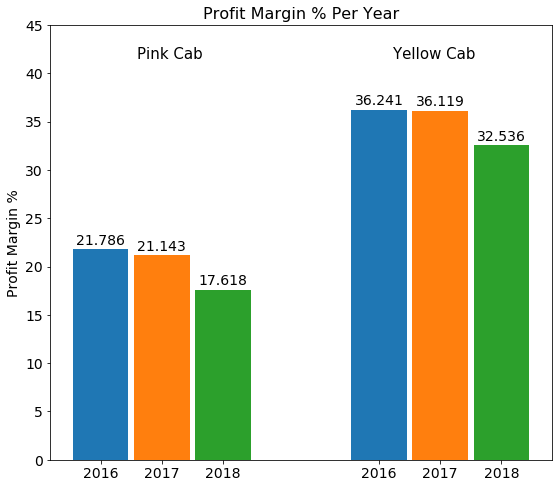

In [37]:
labels = ['2016', '2017', '2018']*2

prof16 = [row[2] for key,row in ProfitMargin_df.iterrows() if row[0] == 2016 ]
prof17 = [row[2] for key,row in ProfitMargin_df.iterrows() if row[0] == 2017 ]
prof18 = [row[2] for key,row in ProfitMargin_df.iterrows() if row[0] == 2018 ]

width = 0.2  # the width of the bars
x1 = np.arange(len(prof16))  # the label locations
x2 = [x + width + 0.02 for x in x1] 
x3 = [x + width + 0.02 for x in x2] 

fig, ax = plt.subplots(figsize=(9,8))
rects1 = ax.bar(x1, prof16, width)
rects2 = ax.bar(x2, prof17, width)
rects3 = ax.bar(x3, prof18, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Profit Margin %',fontsize=14)

ax.set_xticks(np.sort(list(x1)+x2+x3))
ax.set_xticklabels(labels)
ax.tick_params(labelsize=14)

ax.set_ylim(0,45)

def write_labels(positions,values,delt,decimals):
    ''' Plot the values of profit in top of each bar
    Positions: coordinates of each year 
    values: Values of each year '''
    for xpos, ypos in zip(positions, values):
        plt.text(xpos, ypos+delt, f"%.{decimals}f"%ypos, ha="center", va="center",fontsize=14)

write_labels(x1,prof16,0.9,3)
write_labels(x2,prof17,0.9,3)
write_labels(x3,prof18,0.9,3)


ax.set_title('Profit Margin % Per Year',fontsize=16)

plt.text(0.25, 42 ,'Pink Cab', ha="center", va="center",fontsize=15)
plt.text(1.2, 42 ,'Yellow Cab', ha="center", va="center",fontsize=15)


plt.show()

Percentage of rentable rides i.e. (rides with profit>0) for each company per year:

In [38]:
Total_rides_year = Main_df2.groupby(['Date of Travel'])['Company'].value_counts() #Count number of rides per year and company

Main_df2['Rentables'] = Main_df2['Profit']>0 # Create column with rides that gave positive profit
Rentable_rides = Main_df2.groupby(['Date of Travel','Company'])['Rentables'].value_counts() # Count rentable rides

Rentable_rides_per = Rentable_rides/Total_rides_year * 100 # Calculate percentage of rentable rides per year and company
RentableRidesYear_df = pd.DataFrame({'Percentage Rentables':Rentable_rides_per}).reset_index() # Create df
RentableRidesYear_df = RentableRidesYear_df[RentableRidesYear_df['Rentables']==True]
RentableRidesYear_df

C:\Users\erik_\Downloads\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date of Travel,Company,Rentables,Percentage Rentables
0,2016,Pink Cab,True,87.170259
2,2016,Yellow Cab,True,95.306076
4,2017,Pink Cab,True,85.548750
6,2017,Yellow Cab,True,94.778997
8,2018,Pink Cab,True,87.947024
10,2018,Yellow Cab,True,95.004522


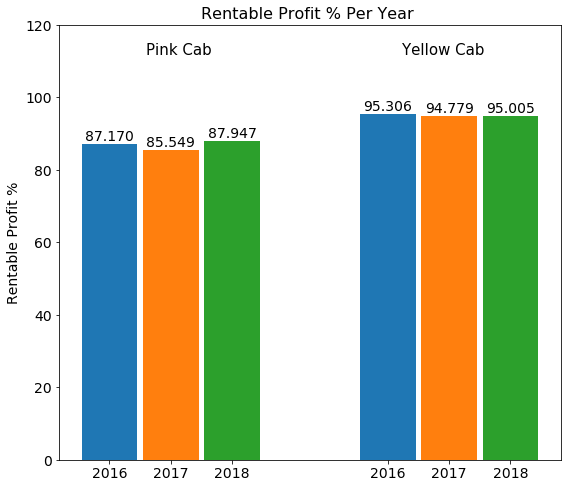

In [39]:
labels = ['2016', '2017', '2018']*2

prof16 = [row[3] for key,row in RentableRidesYear_df.iterrows() if row[0] == 2016 ]
prof17 = [row[3] for key,row in RentableRidesYear_df.iterrows() if row[0] == 2017 ]
prof18 = [row[3] for key,row in RentableRidesYear_df.iterrows() if row[0] == 2018 ]

width = 0.2  # the width of the bars
x1 = np.arange(len(prof16))  # the label locations
x2 = [x + width + 0.02 for x in x1] 
x3 = [x + width + 0.02 for x in x2] 

fig, ax = plt.subplots(figsize=(9,8))
rects1 = ax.bar(x1, prof16, width)
rects2 = ax.bar(x2, prof17, width)
rects3 = ax.bar(x3, prof18, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rentable Profit %',fontsize=14)

ax.set_xticks(np.sort(list(x1)+x2+x3))
ax.set_xticklabels(labels)
ax.tick_params(labelsize=14)

ax.set_ylim(0,120)

def write_labels2(positions,values):
    ''' Plot the values of profit in top of each bar
    Positions: coordinates of each year 
    values: Values of each year '''
    for xpos, ypos in zip(positions, values):
        plt.text(xpos, ypos+2, "%.3f"%ypos, ha="center", va="center",fontsize=14)

write_labels2(x1,prof16)
write_labels2(x2,prof17)
write_labels2(x3,prof18)


ax.set_title('Rentable Profit % Per Year ',fontsize=16)

plt.text(0.25, 113 ,'Pink Cab', ha="center", va="center",fontsize=15)
plt.text(1.2, 113 ,'Yellow Cab', ha="center", va="center",fontsize=15)

# plt.plot([-0.1,1.54],[100,100],'k--', linewidth = 1)
# plt.plot([0.72,0.72],[0,120],'k--', linewidth = 1)

plt.show()

Rentable profits per City:

In [40]:
# Group by cities and calculate the rentable values
Rentable_rides_per_city = Main_df2.groupby(['City','Company'],sort=True)['Rentables'].value_counts() # Count rentable rides per city
TotalRidesCity = Main_df2.groupby(['City'])['Company'].value_counts() # Count total rides per city
rent_rides_city_per = Rentable_rides_per_city/TotalRidesCity * 100 # Percentages of total rentable rides per city

# Create a dataframe with percentages and sum of percentages per city
CityRentables_Df = pd.DataFrame({'Percentages':rent_rides_city_per}).reset_index() # created df
CityRentables_Df = CityRentables_Df[CityRentables_Df['Rentables']==True] # Consider only the True rentables
CityRentables_Df.reset_index(drop=True,inplace=True) # Reset indexes

# Sum the percentages per city to sort the values
Sums_df = (CityRentables_Df.groupby(['City'])['Percentages'].sum()).reset_index()
Sums_df = Sums_df.rename(columns={'Percentages': 'Sums'})

# Merge both DFs
CityRentables_Df = CityRentables_Df.merge(Sums_df)

# Sort by the sum of percentages
CityRentables_Df.sort_values(by=['Sums','City'],ascending=False,inplace=True)
CityRentables_Df.head()

,City,Company,Rentables,Percentages,Sums
32,SILICON VALLEY,Pink Cab,True,96.918620,196.918620
33,SILICON VALLEY,Yellow Cab,True,100.000000,196.918620
18,NEW YORK NY,Pink Cab,True,96.749481,196.749481
19,NEW YORK NY,Yellow Cab,True,100.000000,196.749481
2,AUSTIN TX,Pink Cab,True,92.023555,189.018271


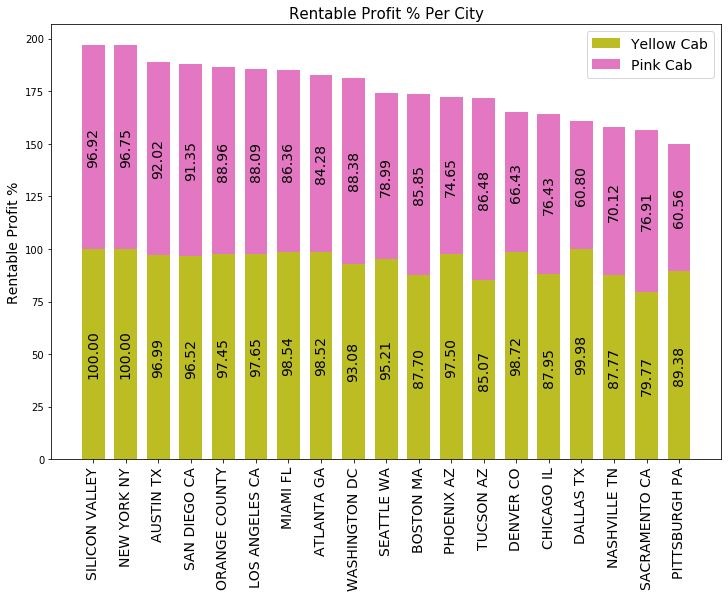

In [41]:
PinkVals = CityRentables_Df[CityRentables_Df['Company'] == 'Pink Cab']['Percentages'].values # Percentages for Pink
YellowVals = CityRentables_Df[CityRentables_Df['Company'] == 'Yellow Cab']['Percentages'].values # Percentages for Yellow

N = len(PinkVals) # Number of bars
ind = np.arange(N)    # the x locations for the groups

cities = CityRentables_Df[CityRentables_Df['Company'] == 'Pink Cab']['City'].values # City names        

width = 0.7       # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(12,8))

p1 = plt.bar(ind, YellowVals, width,color='tab:olive')
p2 = plt.bar(ind, PinkVals, width, bottom=YellowVals ,color='tab:pink')

def plot_vertical_values(xcoords,ycoords,values_array):
    for xpos, ypos, yval in zip(xcoords, ycoords, values_array):
        plt.text(xpos, ypos, "%.2f"%yval, ha="center", va="center",fontsize=14,rotation='vertical')

plot_vertical_values(ind, np.array(YellowVals)/2, YellowVals)
plot_vertical_values(ind, np.array(YellowVals)+np.array(PinkVals)/2, PinkVals)

plt.ylabel('Rentable Profit %',fontsize=14)
plt.title('Rentable Profit % Per City',fontsize=15)
plt.xticks(ind, cities ,fontsize=14,rotation='vertical')
# plt.yticks(np.arange(0, 13,1),fontsize=14)
plt.legend((p1[0], p2[0]), ('Yellow Cab', 'Pink Cab'),fontsize=14)

plt.show()

In [42]:
transaction_comp_city = Main_df2.groupby(['City','Company'])['Transaction ID'].count() 
transaction_city = Main_df2.groupby(['City'])['Transaction ID'].count() 

transaction_comp_city_df=pd.DataFrame({'Trans':transaction_comp_city}).reset_index()
transaction_city_df=pd.DataFrame({'Total Trans':transaction_city}).reset_index()

total_transaction_city=pd.merge(transaction_comp_city_df,transaction_city_df).sort_values(by=['Total Trans','Company'],ascending=False)
total_transaction_city.head()

,City,Company,Trans,Total Trans
19,NEW YORK NY,Yellow Cab,85918,99885
18,NEW YORK NY,Pink Cab,13967,99885
7,CHICAGO IL,Yellow Cab,47264,56625
6,CHICAGO IL,Pink Cab,9361,56625
13,LOS ANGELES CA,Yellow Cab,28168,48033


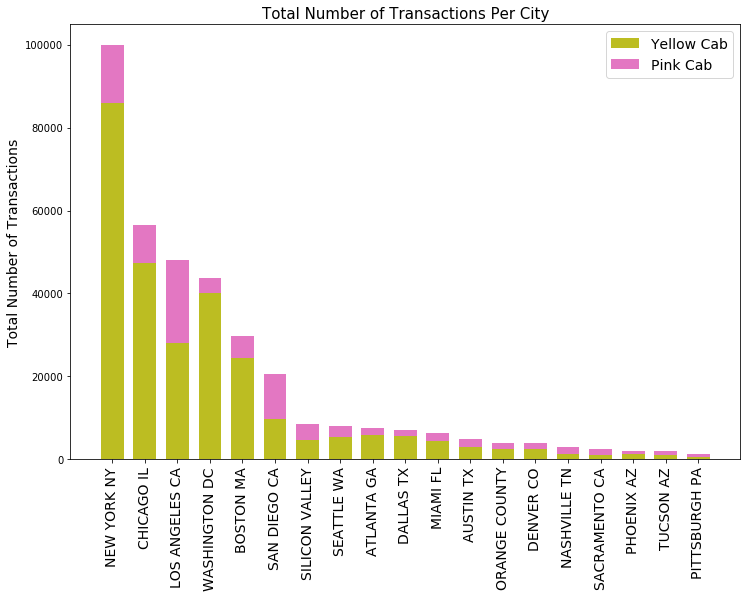

In [43]:
PinkVals = total_transaction_city[total_transaction_city['Company'] == 'Pink Cab']['Trans'].values # Percentages for Pink
YellowVals = total_transaction_city[total_transaction_city['Company'] == 'Yellow Cab']['Trans'].values # Percentages for Yellow

N = len(PinkVals) # Number of bars
ind = np.arange(N)    # the x locations for the groups

cities = total_transaction_city[total_transaction_city['Company'] == 'Pink Cab']['City'].values # City names        

width = 0.7       # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(12,8))

p1 = plt.bar(ind, YellowVals, width,color='tab:olive')
p2 = plt.bar(ind, PinkVals, width, bottom=YellowVals ,color='tab:pink')

# plot_vertical_values(ind, np.array(YellowVals)/2, YellowVals)
# plot_vertical_values(ind, np.array(YellowVals)+np.array(PinkVals)/2, PinkVals)

plt.ylabel('Total Number of Transactions',fontsize=14)
plt.title('Total Number of Transactions Per City',fontsize=15)
plt.xticks(ind, cities ,fontsize=14,rotation='vertical')
# plt.yticks(np.arange(0, 13,1),fontsize=14)
plt.legend((p1[0], p2[0]), ('Yellow Cab', 'Pink Cab'),fontsize=14)
# plt.yscale('log')

plt.show()

In [44]:
transaction_comp_city_per = transaction_comp_city/transaction_city *100
transaction_comp_city_per_df = pd.DataFrame({'Trans Per':transaction_comp_city_per}).reset_index()

YellowSeries = transaction_comp_city_per_df[transaction_comp_city_per_df['Company'] == 'Yellow Cab'].sort_values(by=['Trans Per'],ascending=False)
YellowSeries.drop(columns=['Company'],inplace=True)
YellowSeries.rename(columns={'Trans Per':'Yellow'},inplace=True)

trans_comp_city_per_df = pd.merge(transaction_comp_city_per_df,YellowSeries).sort_values(by=['Yellow','Company'],ascending=False)
trans_comp_city_per_df.head()

,City,Company,Trans Per,Yellow
37,WASHINGTON DC,Yellow Cab,91.558635,91.558635
36,WASHINGTON DC,Pink Cab,8.441365,91.558635
19,NEW YORK NY,Yellow Cab,86.016919,86.016919
18,NEW YORK NY,Pink Cab,13.983081,86.016919
7,CHICAGO IL,Yellow Cab,83.468433,83.468433


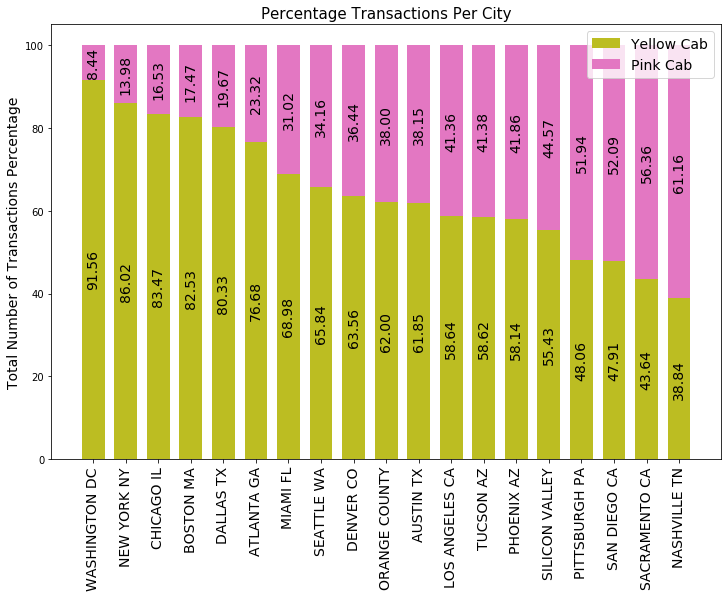

In [45]:
PinkVals = trans_comp_city_per_df[trans_comp_city_per_df['Company'] == 'Pink Cab']['Trans Per'].values # Percentages for Pink
YellowVals = trans_comp_city_per_df[trans_comp_city_per_df['Company'] == 'Yellow Cab']['Trans Per'].values # Percentages for Yellow

N = len(PinkVals) # Number of bars
ind = np.arange(N)    # the x locations for the groups

cities = trans_comp_city_per_df[trans_comp_city_per_df['Company'] == 'Pink Cab']['City'].values # City names        

width = 0.7       # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(12,8))

p1 = plt.bar(ind, YellowVals, width,color='tab:olive')
p2 = plt.bar(ind, PinkVals, width, bottom=YellowVals ,color='tab:pink')

plot_vertical_values(ind, np.array(YellowVals)/2, YellowVals)
plot_vertical_values(ind, np.array(YellowVals)+np.array(PinkVals)/2, PinkVals)

plt.ylabel('Total Number of Transactions Percentage',fontsize=14)
plt.title('Percentage Transactions Per City',fontsize=15)
plt.xticks(ind, cities ,fontsize=14,rotation='vertical')
# plt.plot([0,N-1],[50,50],'k--', linewidth = 1)
plt.legend((p1[0], p2[0]), ('Yellow Cab', 'Pink Cab'),fontsize=14)

plt.show()

The city with more Yellow cab transactions is New York and the city with more Pink Cab transactions in Los Angeles CA. On the other side of all the transactions made in Pittsburg, San Diego, Sacramento and Nashville, in each city the Pink cab company have more percentage of transactions. In the rest of the cities the Yellow Cab has the dominance percentage of transactions. Both companies have good income in New York (Yellow dominates). In San diego there are over 20000 transactions and Pink dominates.

Total Profit in 3 years for each company, total of rides and profit per rides

In [46]:
TotalProfit = Main_df2.groupby(['Company'])['Profit'].sum() # Total sum of profits per company in 3 years
TotalRides = Main_df2['Company'].value_counts() # Count the total rides per company
ProfitPerRide = TotalProfit/TotalRides # Average profit per ride
Resumedf = pd.DataFrame({'Company':['Pink Cab','Yellow Cab'],'Profit':TotalProfit,
                        'Total Rides':TotalRides,'Profit Per Ride':ProfitPerRide})
Resumedf

,Company,Profit,Total Rides,Profit Per Ride
Pink Cab,Pink Cab,5.307328e+06,84711,62.652174
Yellow Cab,Yellow Cab,4.402037e+07,274681,160.259986


Total of profits per year for both companies and the profit increment between years

In [47]:
Total_Profits_Year = Main_df2.groupby(['Date of Travel','Company'])['Profit'].sum()
Total_Profits_Year_df = pd.DataFrame({'Percentages':Total_Profits_Year}).reset_index()
Total_Profits_Year_df

,Date of Travel,Company,Percentages
0,2016,Pink Cab,1.739883e+06
1,2016,Yellow Cab,1.407389e+07
2,2017,Pink Cab,2.015101e+06
3,2017,Yellow Cab,1.646427e+07
4,2018,Pink Cab,1.552345e+06
5,2018,Yellow Cab,1.348222e+07


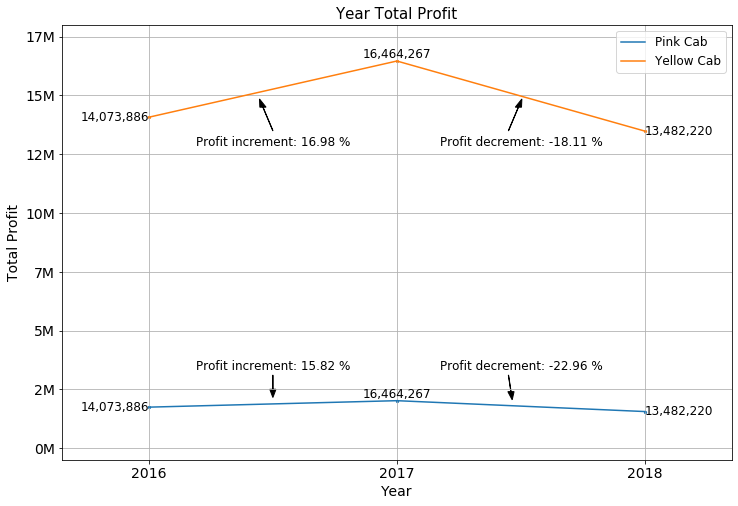

In [48]:
fig,ax = plt.subplots(figsize=(12,8))

ind = list(range(3))
years = ['2016','2017','2018']

# Profits per year
YellowTotalProf = np.array([row[2] for key,row in Total_Profits_Year_df.iterrows() if row[1] == 'Yellow Cab' ])
PinkTotalProf = np.array([row[2] for key,row in Total_Profits_Year_df.iterrows() if row[1] == 'Pink Cab' ])

# Profit increment per year
YellowIncrements = (np.roll(YellowTotalProf,-1) - YellowTotalProf)/YellowTotalProf * 100 # Calculate the increments from one year to next
PinkIncrements = (np.roll(PinkTotalProf,-1) - PinkTotalProf)/PinkTotalProf * 100

# Scatter Plot
plt.scatter(years , PinkTotalProf *10e-7 ,s=5)
plt.scatter(years , YellowTotalProf *10e-7,s=5)

# Lineplot
plt.plot(years , PinkTotalProf *10e-7,label = 'Pink Cab')
plt.plot(years , YellowTotalProf * 10e-7, label = 'Yellow Cab')

# Add text for the profit values of each year

def plot_coor_vals(indexes,xcoords,ycoords,yvals):
    for idx,xpos, ypos,yval in zip(indexes,xcoords,ycoords,yvals):
        if idx == 0:
            plt.text(xpos, ypos, "{:,}".format(int("%.0f"%yval)),ha="right",va="center",fontsize=12)
        elif idx == 1:
            plt.text(xpos, ypos, "{:,}".format(int("%.0f"%yval)),ha="center",va="bottom",fontsize=12)
        elif idx == 2:
            plt.text(xpos , ypos,"{:,}".format(int("%.0f"%yval)),ha="left",va="center",fontsize=12)
    
plot_coor_vals(ind,years,YellowTotalProf*10e-7,YellowTotalProf)
plot_coor_vals(ind,years,PinkTotalProf*10e-7,YellowTotalProf)

# Add text for the increments in percentage:

plt.text(0.5,13,"Profit increment: %.2f"%YellowIncrements[0]+' %',ha="center",va="center",fontsize=12)
plt.text(1.5,13,"Profit decrement: %.2f"%YellowIncrements[1]+' %',ha="center",va="center",fontsize=12)
plt.text(0.5,3.5,"Profit increment: %.2f"%PinkIncrements[0]+' %',ha="center",va="center",fontsize=12)
plt.text(1.5,3.5,"Profit decrement: %.2f"%PinkIncrements[1]+' %',ha="center",va="center",fontsize=12)

plt.arrow(0.5,13.5,-0.04,1,head_width=0.025,head_length=0.35,color='k')
plt.arrow(1.45,13.5,0.04,1,head_width=0.025,head_length=0.35,color='k')
plt.arrow(0.5,3.1,0.,-0.6,head_width=0.025,head_length=0.35,color='k')
plt.arrow(1.45,3.1,0.01,-0.7,head_width=0.025,head_length=0.35,color='k')

# Title and labels
plt.title('Year Total Profit',fontsize=15)
plt.ylabel('Total Profit',fontsize=14)
plt.xlabel('Year',fontsize=14)

plt.xlim([-0.35, 2.35])
plt.ylim([-0.5,18])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Format
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%dM"))

plt.grid(True)
plt.legend(fontsize=12)
plt.show()

Number of transactions per year and per month for both companies

In [49]:
transactions_year = Main_df2.groupby(['Date of Travel','Company'])['Transaction ID'].count() # total transactions per year and company

transactions_year_df = pd.DataFrame({'Transactions':transactions_year }).reset_index() # Create df
transactions_year_df

,Date of Travel,Company,Transactions
0,2016,Pink Cab,25285
1,2016,Yellow Cab,82937
2,2017,Pink Cab,30205
3,2017,Yellow Cab,97759
4,2018,Pink Cab,29221
5,2018,Yellow Cab,93985


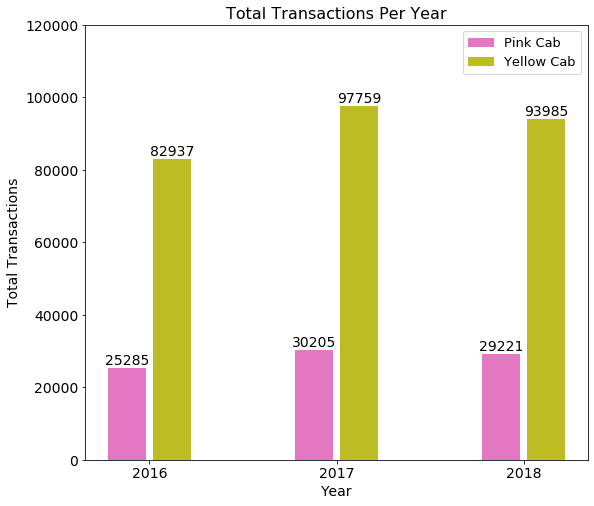

In [50]:
labels = ['2016', '2017', '2018']

PinkV = [row[2] for key,row in transactions_year_df.iterrows() if row[1] == 'Pink Cab' ]
YellowV = [row[2] for key,row in transactions_year_df.iterrows() if row[1] == 'Yellow Cab' ]


width = 0.2  # the width of the bars
x1 = np.arange(len(labels))  # the label locations
x2 = [x - width/2 - 0.02  for x in x1] # Pink Locations
x3 = [x + width/2 + 0.02 for x in x1] # Yellow Locations

fig, ax = plt.subplots(figsize=(9,8))

rects2 = ax.bar(x2, PinkV, width,label='Pink Cab',color='tab:pink')
rects3 = ax.bar(x3, YellowV, width,label='Yellow Cab',color='tab:olive')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Transactions',fontsize=14)
ax.set_xlabel('Year',fontsize=14)

ax.set_xticks(x1)
ax.set_xticklabels(labels)
ax.tick_params(labelsize=14)

ax.set_ylim(0,120000)

write_labels(x2,PinkV,2000,0)
write_labels(x3,YellowV,2000,0)

ax.set_title('Total Transactions Per Year',fontsize=16)

plt.legend(fontsize=13)

plt.show()

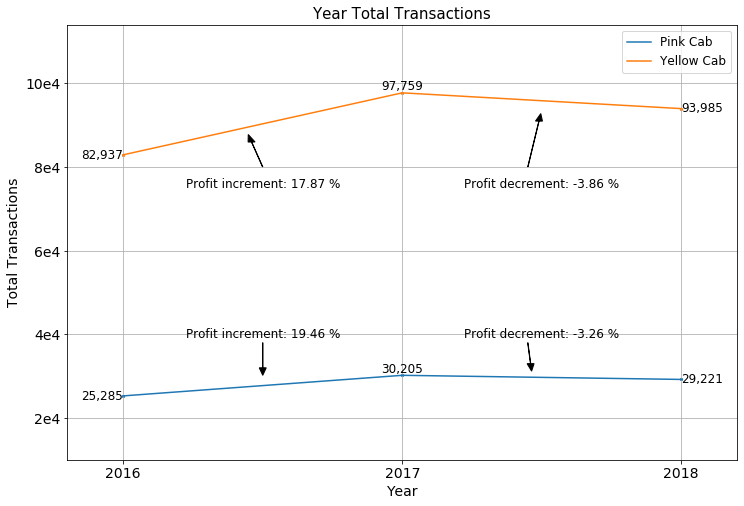

In [51]:
fig,ax = plt.subplots(figsize=(12,8))

# Profits per year
YellowTotalProf = np.array([row[2] for key,row in transactions_year_df.iterrows() if row[1] == 'Yellow Cab' ])
PinkTotalProf = np.array([row[2] for key,row in transactions_year_df.iterrows() if row[1] == 'Pink Cab' ])

# Profit increment per year
YellowIncrements = (np.roll(YellowTotalProf,-1) - YellowTotalProf)/YellowTotalProf * 100 # Calculate the increments from one year to next
PinkIncrements = (np.roll(PinkTotalProf,-1) - PinkTotalProf)/PinkTotalProf * 100

# Scatter Plot
plt.scatter(years , PinkTotalProf*1e-4 ,s=5)
plt.scatter(years , YellowTotalProf *1e-4,s=5)

# Lineplot
plt.plot(years , PinkTotalProf *1e-4,label = 'Pink Cab')
plt.plot(years , YellowTotalProf *1e-4, label = 'Yellow Cab')

# Add text for the profit values of each year

plot_coor_vals(ind,years,YellowTotalProf*1e-4,YellowTotalProf)
plot_coor_vals(ind,years,PinkTotalProf*1e-4,PinkTotalProf)

# Add text for the increments in percentage:

plt.text(0.5,7.6,"Profit increment: %.2f"%YellowIncrements[0]+' %',ha="center",va="center",fontsize=12)
plt.text(1.5,7.6,"Profit decrement: %.2f"%YellowIncrements[1]+' %',ha="center",va="center",fontsize=12)
plt.text(0.5,4,"Profit increment: %.2f"%PinkIncrements[0]+' %',ha="center",va="center",fontsize=12)
plt.text(1.5,4,"Profit decrement: %.2f"%PinkIncrements[1]+' %',ha="center",va="center",fontsize=12)

plt.arrow(0.5,8,-0.04,0.6,head_width=0.025,head_length=0.18,color='k')
plt.arrow(1.45,8,0.04,1.1,head_width=0.025,head_length=0.18,color='k')
plt.arrow(0.5,3.8,0.,-0.6,head_width=0.025,head_length=0.18,color='k')
plt.arrow(1.45,3.8,0.01,-0.5,head_width=0.025,head_length=0.18,color='k')

# Title and labels
plt.title('Year Total Transactions',fontsize=15)
plt.ylabel('Total Transactions',fontsize=14)
plt.xlabel('Year',fontsize=14)

plt.xlim([-0.2, 2.2])
plt.ylim([1,11.4])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Format
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%de4"))

plt.grid(True)
plt.legend(fontsize=12)
plt.show()

Despite the Yellow Cab has more transactions each year, Pink cab company has a better increment perfomance over the years. It can be seen that is growing much faster than the Yellow Cab company.

In [52]:
transactions_month = Main_df2.groupby(['Month','Company'])['Transaction ID'].count() # total transaction per month and company

transactions_month_df = pd.DataFrame({'Transactions':transactions_month }).reset_index() # Create df
transactions_month_df.head()

,Month,Company,Transactions
0,1,Pink Cab,4825
1,1,Yellow Cab,17468
2,2,Pink Cab,3392
3,2,Yellow Cab,14928
4,3,Pink Cab,4228


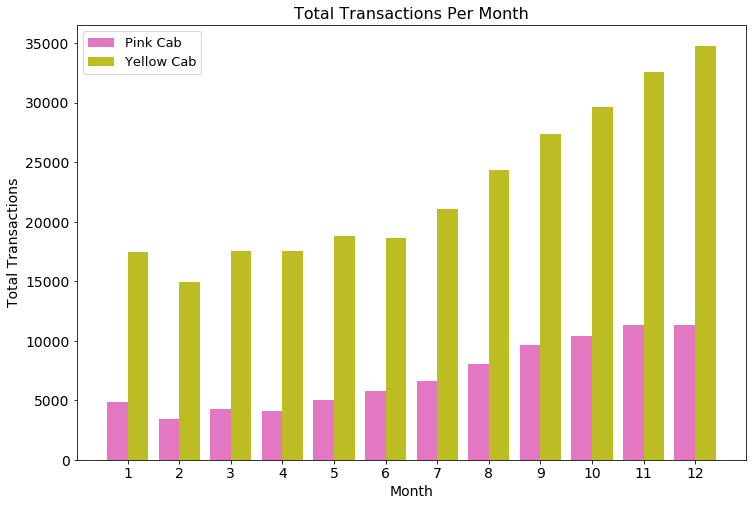

In [53]:
labels = list(set(transactions_month_df['Month']))

PinkV = [row[2] for key,row in transactions_month_df.iterrows() if row[1] == 'Pink Cab' ]
YellowV = [row[2] for key,row in transactions_month_df.iterrows() if row[1] == 'Yellow Cab' ]

width = 0.4  # the width of the bars
x1 = np.arange(len(labels))  # the label locations
x2 = [x - width/2   for x in x1] # Pink Locations
x3 = [x + width/2  for x in x1] # Yellow Locations

fig, ax = plt.subplots(figsize=(12,8))

rects2 = ax.bar(x2, PinkV, width,label='Pink Cab',color='tab:pink')
rects3 = ax.bar(x3, YellowV, width,label='Yellow Cab',color='tab:olive')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Transactions',fontsize=14)
ax.set_xlabel('Month',fontsize=14)

ax.set_xticks(x1)
ax.set_xticklabels(labels)
ax.tick_params(labelsize=14)

# ax.set_ylim(0,120000)

# write_labels(x2,PinkV,500,0)
# write_labels(x3,YellowV,500,0)

ax.set_title('Total Transactions Per Month',fontsize=16)

plt.legend(fontsize=13)

plt.show()

it is necessary to analyze the vacation days and the daily analysis

In [54]:
weeks = Main_df2.groupby(['Date of Travel'])['Week'].value_counts()
weeks_pd = pd.DataFrame({'Counts':weeks}).reset_index()
num_of_weeks = weeks_pd.shape[0]
num_of_weeks

157

In [55]:
transactions_day = Main_df2.groupby(['Day of Week','Company'])['Transaction ID'].count()/num_of_weeks # average transactions per day and company
transactions_day_df = pd.DataFrame({'Transactions':transactions_day }).reset_index() # Create df
transactions_day_df.head()

,Day of Week,Company,Transactions
0,0,Pink Cab,45.076433
1,0,Yellow Cab,145.114650
2,1,Pink Cab,45.070064
3,1,Yellow Cab,146.662420
4,2,Pink Cab,60.821656


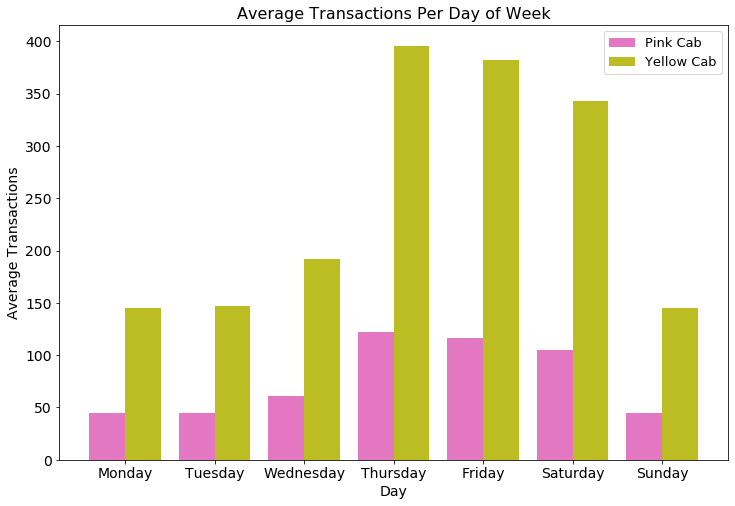

In [56]:
labels = list(set(transactions_day_df['Day of Week']))
labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

PinkV = [row[2] for key,row in transactions_day_df.iterrows() if row[1] == 'Pink Cab' ]
YellowV = [row[2] for key,row in transactions_day_df.iterrows() if row[1] == 'Yellow Cab' ]

width = 0.4  # the width of the bars
x1 = np.arange(len(labels))  # the label locations
x2 = [x - width/2   for x in x1] # Pink Locations
x3 = [x + width/2  for x in x1] # Yellow Locations

fig, ax = plt.subplots(figsize=(12,8))

rects2 = ax.bar(x2, PinkV, width,label='Pink Cab',color='tab:pink')
rects3 = ax.bar(x3, YellowV, width,label='Yellow Cab',color='tab:olive')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Transactions',fontsize=14)
ax.set_xlabel('Day',fontsize=14)

ax.set_xticks(x1)
ax.set_xticklabels(labels)
ax.tick_params(labelsize=14)

# ax.set_ylim(0,120000)

# write_labels(x2,PinkV,500,0)
# write_labels(x3,YellowV,500,0)

ax.set_title('Average Transactions Per Day of Week',fontsize=16)

plt.legend(fontsize=13)

plt.show()

In [57]:
transactions_day_prof = Main_df2.groupby(['Day of Week','Company'])['Profit'].sum()/num_of_weeks # total transaction per month and company
transactions_day_prof_df = pd.DataFrame({'Transactions':transactions_day_prof }).reset_index() # Create df
transactions_day_prof_df

,Day of Week,Company,Transactions
0,0,Pink Cab,2158.760879
1,0,Yellow Cab,20253.757312
2,1,Pink Cab,2146.269191
3,1,Yellow Cab,20232.722662
4,2,Pink Cab,2862.767083
5,2,Yellow Cab,26376.131149
6,3,Pink Cab,8491.651955
7,3,Yellow Cab,67196.243396
8,4,Pink Cab,7869.471217
9,4,Yellow Cab,63964.401957


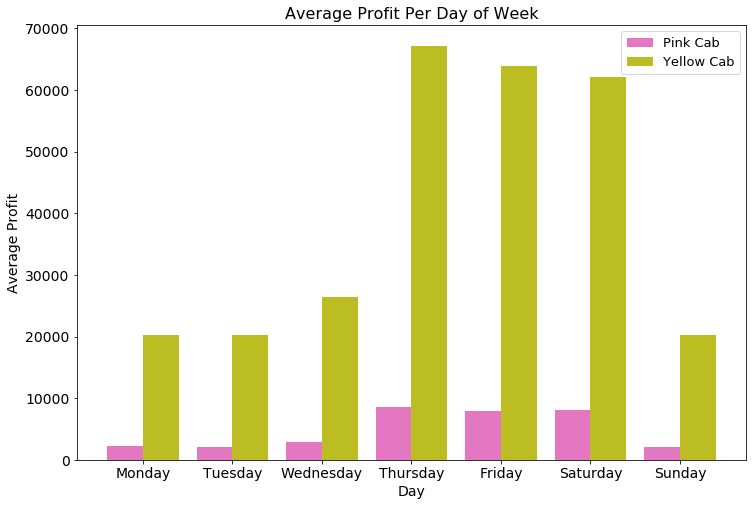

In [58]:
labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

PinkV = [row[2] for key,row in transactions_day_prof_df.iterrows() if row[1] == 'Pink Cab' ]
YellowV = [row[2] for key,row in transactions_day_prof_df.iterrows() if row[1] == 'Yellow Cab' ]

width = 0.4  # the width of the bars
x1 = np.arange(len(labels))  # the label locations
x2 = [x - width/2   for x in x1] # Pink Locations
x3 = [x + width/2  for x in x1] # Yellow Locations

fig, ax = plt.subplots(figsize=(12,8))

rects2 = ax.bar(x2, PinkV, width,label='Pink Cab',color='tab:pink')
rects3 = ax.bar(x3, YellowV, width,label='Yellow Cab',color='tab:olive')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Profit',fontsize=14)
ax.set_xlabel('Day',fontsize=14)

ax.set_xticks(x1)
ax.set_xticklabels(labels)
ax.tick_params(labelsize=14)

# ax.set_ylim(0,120000)

# write_labels(x2,PinkV,500,0)
# write_labels(x3,YellowV,500,0)

ax.set_title('Average Profit Per Day of Week',fontsize=16)

plt.legend(fontsize=13)

plt.show()

From the day of week analysis we can observe that the average number of transactions per day of week is 3 times higher for the Yellow Cab company. On the other side the average profit per day of week is almost 10 times higher for the Yellow Cab company. For both companies and for both measurements thursday is the day of the week with more transactions and income.

## Analysis 2: Gender, Income and Age Analysis

In [59]:
profit_gender_year = Main_df2.groupby(['Company','Gender','Date of Travel'])['Profit'].sum() # Total profit by year, comp 
                                                                                             # and gender
profit_com_year = Main_df2.groupby(['Company','Date of Travel'])['Profit'].sum() # Total profit by company and year
profit_gender_per = round(profit_gender_year/profit_com_year * 100) # Percentage
profit_gender_per_df = pd.DataFrame({'Transactions':profit_gender_per }).reset_index() # Create df
profit_gender_per_df = profit_gender_per_df[['Company','Gender','Date of Travel','Transactions']] # Reorder columns
profit_gender_per_df.sort_values(by=['Company','Gender','Date of Travel'],inplace=True) # Sort
profit_gender_per_df

,Company,Gender,Date of Travel,Transactions
0,Pink Cab,Female,2016,43.0
2,Pink Cab,Female,2017,44.0
4,Pink Cab,Female,2018,45.0
1,Pink Cab,Male,2016,57.0
3,Pink Cab,Male,2017,56.0
5,Pink Cab,Male,2018,55.0
6,Yellow Cab,Female,2016,40.0
8,Yellow Cab,Female,2017,42.0
10,Yellow Cab,Female,2018,42.0
7,Yellow Cab,Male,2016,60.0


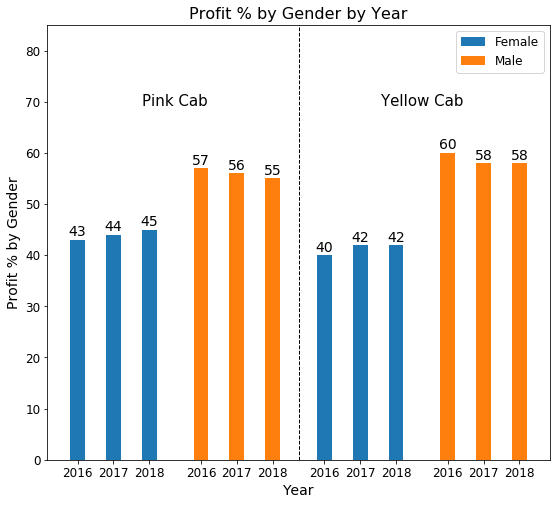

In [60]:
labels = ['2016', '2017', '2018'] * 4


PinkF = [row[3] for key,row in profit_gender_per_df.iterrows() if row[0] == 'Pink Cab' and row[1] == 'Female']
PinkM = [row[3] for key,row in profit_gender_per_df.iterrows() if row[0] == 'Pink Cab' and row[1] == 'Male']

YellowF = [row[3] for key,row in profit_gender_per_df.iterrows() if row[0] == 'Yellow Cab' and row[1] == 'Female' ]
YellowM = [row[3] for key,row in profit_gender_per_df.iterrows() if row[0] == 'Yellow Cab' and row[1] == 'Male' ]

width = 0.12  # the width of the bars
x1 = np.arange(4)  # the label locations
xs = [[],[],[],[]]
for idx,x in enumerate(x1):
    xs[idx].append(x - 0.29)
    xs[idx].append(x)
    xs[idx].append(x + 0.29)
    
fig, ax = plt.subplots(figsize=(9,8))

for idx,xpos,dat in zip(x1,xs,[PinkF,PinkM,YellowF,YellowM]):
    if idx%2 == 0:
        color = 'tab:blue'
        if idx == 0: lbl = 'Female'
        else: lbl = ''
    else:
        color = 'tab:orange'
        if idx == 1: lbl = 'Male'
        else: lbl = ''
    barplot = ax.bar(xpos,dat,width,label=lbl,color=color)
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Profit % by Gender',fontsize=14)
ax.set_xlabel('Year',fontsize=14)

ax.set_xticks(np.array(xs).flatten())
ax.set_xticklabels(labels)
ax.tick_params(labelsize=12)

ax.set_ylim(0,85)
# ax.set_xlim(-0.6,4.0)

for xpos,dat in zip(xs,[PinkF,PinkM,YellowF,YellowM]):  
    write_labels(xpos,dat,1.5,0)

ax.set_title('Profit % by Gender by Year',fontsize=16)
plt.text(0.5, 70 ,'Pink Cab', ha="center", va="center",fontsize=15)
plt.text(2.5, 70 ,'Yellow Cab', ha="center", va="center",fontsize=15)


# plt.plot([-0.5,1.54],[65,65],'k--', linewidth = 1)
plt.plot([1.5,1.5],[0,90],'k--', linewidth = 1)

plt.legend(fontsize=12)
plt.show()

In [61]:
profit_gender_year2 = Main_df2.groupby(['Gender','Date of Travel','Company'])['Profit'].sum() # Total profit by year, comp 
                                                                                             # and gender

profit_com_year2 = Main_df2.groupby(['Gender','Date of Travel','Company'])['Profit'].count() # Total profit by company and year

profit_gender_ave2 = profit_gender_year2/profit_com_year2 # Percentage
profit_gender_ave2_df = pd.DataFrame({'Average Profit':profit_gender_ave2}).reset_index() # Create df
profit_gender_ave2_df = profit_gender_ave2_df[['Gender','Company','Date of Travel','Average Profit']] # Reorder columns
profit_gender_ave2_df.sort_values(by=['Gender','Company','Date of Travel'],inplace=True) # Sort
profit_gender_ave2_df

,Gender,Company,Date of Travel,Average Profit
0,Female,Pink Cab,2016,68.263839
2,Female,Pink Cab,2017,66.167101
4,Female,Pink Cab,2018,53.005715
1,Female,Yellow Cab,2016,165.244099
3,Female,Yellow Cab,2017,164.746266
5,Female,Yellow Cab,2018,139.988446
6,Male,Pink Cab,2016,69.229723
8,Male,Pink Cab,2017,67.151279
10,Male,Pink Cab,2018,53.220641
7,Male,Yellow Cab,2016,172.810046


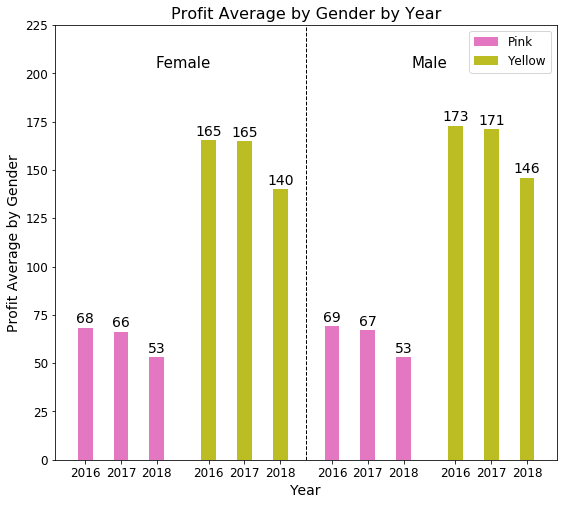

In [62]:
labels = ['2016', '2017', '2018'] * 4


PinkF = [row[3] for key,row in profit_gender_ave2_df.iterrows() if row[0] == 'Female' and row[1] == 'Pink Cab' ]
PinkM = [row[3] for key,row in profit_gender_ave2_df.iterrows() if row[0] == 'Female'  and row[1] == 'Yellow Cab']

YellowF = [row[3] for key,row in profit_gender_ave2_df.iterrows() if row[0] == 'Male' and row[1] == 'Pink Cab']
YellowM = [row[3] for key,row in profit_gender_ave2_df.iterrows() if row[0] == 'Male' and row[1] == 'Yellow Cab']

width = 0.12  # the width of the bars
x1 = np.arange(4)  # the label locations
xs = [[],[],[],[]]
for idx,x in enumerate(x1):
    xs[idx].append(x - 0.29)
    xs[idx].append(x)
    xs[idx].append(x + 0.29)
    
fig, ax = plt.subplots(figsize=(9,8))

for idx,xpos,dat in zip(x1,xs,[PinkF,PinkM,YellowF,YellowM]):
    if idx%2 == 0:
        color = 'tab:pink'
        if idx == 0: lbl = 'Pink'
        else: lbl = ''
    else:
        color = 'tab:olive'
        if idx == 1: lbl = 'Yellow'
        else: lbl = ''
    barplot = ax.bar(xpos,dat,width,label=lbl,color=color)
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Profit Average by Gender',fontsize=14)
ax.set_xlabel('Year',fontsize=14)

ax.set_xticks(np.array(xs).flatten())
ax.set_xticklabels(labels)
ax.tick_params(labelsize=12)

ax.set_ylim(0,225)
# ax.set_xlim(-0.6,4.0)

for xpos,dat in zip(xs,[PinkF,PinkM,YellowF,YellowM]):  
    write_labels(xpos,dat,4.5,0)

ax.set_title('Profit Average by Gender by Year',fontsize=16)
plt.text(0.5, 205 ,'Female', ha="center", va="center",fontsize=15)
plt.text(2.5, 205 ,'Male', ha="center", va="center",fontsize=15)


# plt.plot([-0.5,1.54],[65,65],'k--', linewidth = 1)
plt.plot([1.5,1.5],[0,225],'k--', linewidth = 1)

plt.legend(fontsize=12)
plt.show()

For each company per year the profit contributed is greater in male customers than in female customers in both companies. 
In both genders the contributions by year is always greater in the yellow cab company. 

In [63]:
customer_gender_year = Main_df2.groupby(['Company','Gender','Date of Travel'])['Transaction ID'].count() # Total profit by year, comp 
                                                                                                 # and gender

customer_com_year = Main_df2.groupby(['Company','Date of Travel'])['Profit'].count() # Total profit by company and year
customer_gender_per = round(customer_gender_year/customer_com_year * 100) # Percentage
customer_gender_per_df = pd.DataFrame({'Transactions':customer_gender_per }).reset_index() # Create df
customer_gender_per_df = customer_gender_per_df[['Company','Gender','Date of Travel','Transactions']] # Reorder columns
customer_gender_per_df.sort_values(by=['Company','Gender','Date of Travel'],inplace=True) # Sort
customer_gender_per_df

,Company,Gender,Date of Travel,Transactions
0,Pink Cab,Female,2016,43.0
2,Pink Cab,Female,2017,44.0
4,Pink Cab,Female,2018,45.0
1,Pink Cab,Male,2016,57.0
3,Pink Cab,Male,2017,56.0
5,Pink Cab,Male,2018,55.0
6,Yellow Cab,Female,2016,41.0
8,Yellow Cab,Female,2017,43.0
10,Yellow Cab,Female,2018,43.0
7,Yellow Cab,Male,2016,59.0


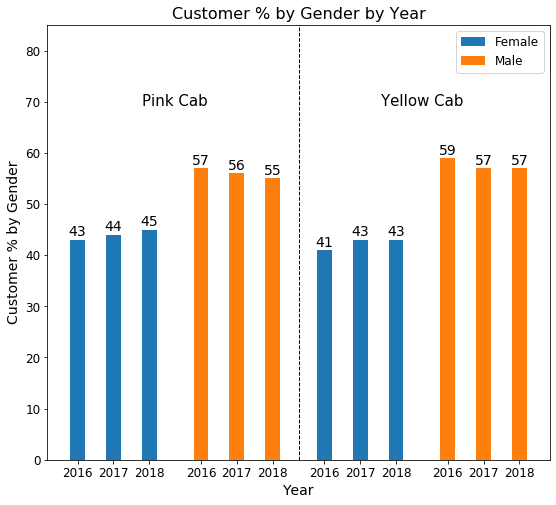

In [64]:
labels = ['2016', '2017', '2018'] * 4


PinkF = [row[3] for key,row in customer_gender_per_df.iterrows() if row[0] == 'Pink Cab' and row[1] == 'Female']
PinkM = [row[3] for key,row in customer_gender_per_df.iterrows() if row[0] == 'Pink Cab' and row[1] == 'Male']

YellowF = [row[3] for key,row in customer_gender_per_df.iterrows() if row[0] == 'Yellow Cab' and row[1] == 'Female' ]
YellowM = [row[3] for key,row in customer_gender_per_df.iterrows() if row[0] == 'Yellow Cab' and row[1] == 'Male' ]

width = 0.12  # the width of the bars
x1 = np.arange(4)  # the label locations
xs = [[],[],[],[]]
for idx,x in enumerate(x1):
    xs[idx].append(x - 0.29)
    xs[idx].append(x)
    xs[idx].append(x + 0.29)
    
fig, ax = plt.subplots(figsize=(9,8))

for idx,xpos,dat in zip(x1,xs,[PinkF,PinkM,YellowF,YellowM]):
    if idx%2 == 0:
        color = 'tab:blue'
        if idx == 0: lbl = 'Female'
        else: lbl = ''
    else:
        color = 'tab:orange'
        if idx == 1: lbl = 'Male'
        else: lbl = ''
    barplot = ax.bar(xpos,dat,width,label=lbl,color=color)
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Customer % by Gender',fontsize=14)
ax.set_xlabel('Year',fontsize=14)

ax.set_xticks(np.array(xs).flatten())
ax.set_xticklabels(labels)
ax.tick_params(labelsize=12)

ax.set_ylim(0,85)
# ax.set_xlim(-0.6,4.0)

for xpos,dat in zip(xs,[PinkF,PinkM,YellowF,YellowM]):  
    write_labels(xpos,dat,1.5,0)

ax.set_title('Customer % by Gender by Year',fontsize=16)
plt.text(0.5, 70 ,'Pink Cab', ha="center", va="center",fontsize=15)
plt.text(2.5, 70 ,'Yellow Cab', ha="center", va="center",fontsize=15)


# plt.plot([-0.5,1.54],[65,65],'k--', linewidth = 1)
plt.plot([1.5,1.5],[0,90],'k--', linewidth = 1)

plt.legend(fontsize=12)
plt.show()

We divide the customers in three categories by income. Percentile 1 is the 33.333% and percentile 2 66.666%. With this division we calculate the profit % of each range.

#### Yearly income

Low Class: Income < \\$30'000

Middle Class: \\$30'000 <= Income < \\$180'000

High Class: \\$180'000 < Income 

In [65]:
# per1 = np.percentile(Main_df2['Income (USD/Month)'] , 19) # Percentile 1 
# per2 = np.percentile(Main_df2['Income (USD/Month)'] , 71) # Percentile 2
# print(per1,per2)

per1 = 30000/12
per2 = 180000/12
print('Low income per month: ',per1)
print('Middle income per month: ',per2)


Low income per month:  2500.0
Middle income per month:  15000.0


In [66]:
low_list = np.where(np.array(Main_df2['Income (USD/Month)']) <= per1, 'Low',None) # Low list: values lower than per1
middle_list = np.where((per1 < np.array(Main_df2['Income (USD/Month)'])) & 
                       (np.array(Main_df2['Income (USD/Month)']) <= per2), 
                       'Middle',None) # Middle list: values greater than per1 and smaller than per2
high_list = np.where(np.array(Main_df2['Income (USD/Month)']) > per2, 'High',None) # High list: values bigger than per2

In [67]:
econ_classes = [] # Big list to store the economic classes
for l,m,h in zip(low_list,middle_list,high_list): # Loop through the 3 classes lists
    three_vals = np.array([l,m,h]) 
    true_val = three_vals != None # Determine element != None
    idx = list(true_val).index(True) # Find index
    econ_class = three_vals[idx] # Find element, it can be Low, Middle or High
    econ_classes.append(econ_class) # Store it in list

In [68]:
Main_df2['Economic Class'] = pd.Series(econ_classes,name='Economic Class') # Create new column of Economic Class

C:\Users\erik_\Downloads\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
profit_income = Main_df2.groupby(['Date of Travel','Company','Economic Class'])['Profit'].sum()
profit_income_df = pd.DataFrame({'Profit Contribute':profit_income}).reset_index()

customer_income_count = Main_df2.groupby(['Date of Travel','Company','Economic Class'])['Profit'].count()
customer_income_count_df = pd.DataFrame({'Num of Customers':customer_income_count }).reset_index()
profit_income_ave = profit_income/customer_income_count # Percentage
profit_income_ave_df = pd.DataFrame({'Average Profit Contribute':profit_income_ave }).reset_index() # Create df
profit_income_ave_df

# customer_gender_per_df = customer_gender_per_df[['Company','Gender','Date of Travel','Transactions']] # Reorder columns
# customer_gender_per_df.sort_values(by=['Company','Gender','Date of Travel'],inplace=True) # Sort
# customer_gender_per_df

,Date of Travel,Company,Economic Class,Average Profit Contribute
0,2016,Pink Cab,High,70.097596
1,2016,Pink Cab,Low,62.844012
2,2016,Pink Cab,Middle,67.750849
3,2016,Yellow Cab,High,171.590672
4,2016,Yellow Cab,Low,165.380296
5,2016,Yellow Cab,Middle,167.982976
6,2017,Pink Cab,High,66.805546
7,2017,Pink Cab,Low,68.973277
8,2017,Pink Cab,Middle,66.532279
9,2017,Yellow Cab,High,170.732181


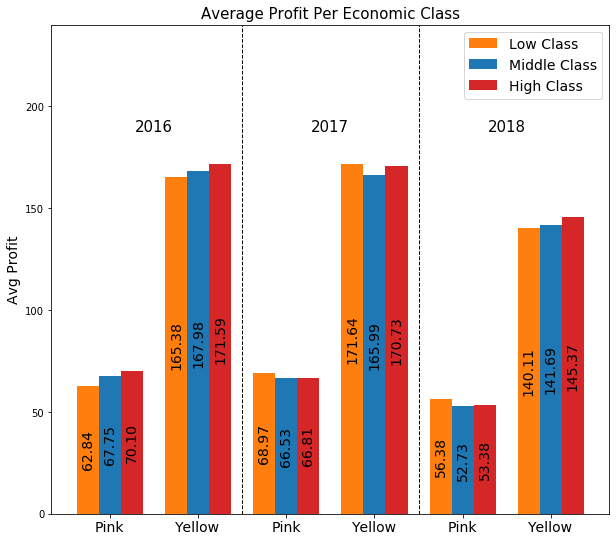

In [70]:
N = 6

cabs = ['Pink','Yellow']*3

LowVals = [row[3] for key,row in profit_income_ave_df.iterrows() if row[2] == 'Low' ]
MiddleVals = [row[3] for key,row in profit_income_ave_df.iterrows() if row[2] == 'Middle' ]
HighVals = [row[3] for key,row in profit_income_ave_df.iterrows() if row[2] == 'High']

width = 0.25

ind = np.arange(N)
ind1 = [x-width for x in ind]
ind2 = [x+width for x in ind]


plt.figure(figsize=(10,9))

p1 = plt.bar(ind1, LowVals, width , color='tab:orange',label='Low Class')
p2 = plt.bar(ind, MiddleVals, width, color='tab:blue',label='Middle Class')
p3 = plt.bar(ind2, HighVals, width ,color='tab:red',label='High Class')

plot_vertical_values(ind1, np.array(LowVals)/2,LowVals)
plot_vertical_values(ind, np.array(MiddleVals)/2,MiddleVals)
plot_vertical_values(ind2, np.array(HighVals)/2,HighVals)

plt.text(0.5, 190 ,'2016', ha="center", va="center",fontsize=15)
plt.text(2.5, 190 ,'2017', ha="center", va="center",fontsize=15)
plt.text(4.5, 190 ,'2018', ha="center", va="center",fontsize=15)

plt.ylabel('Avg Profit',fontsize=14)
plt.title('Average Profit Per Economic Class',fontsize=15)
plt.xticks(ind, cabs ,fontsize=14)

plt.ylim(0,240)
plt.plot([1.5,1.5],[0,240],'k--', linewidth = 1)
plt.plot([3.5,3.5],[0,240],'k--', linewidth = 1)
plt.legend(fontsize=14)

plt.show()

In the Yellow Cab company we can see that the high class pays more in 2016 and 2018. In the other hand, the low class paid more in 2017 in both companies. A posible hypothesis is that the high class customers prefer the Yellow Cab company over the Pink Cab company

In [71]:
customer_count_year = Main_df2.groupby(['Company','Customer ID'])['Transaction ID'].count()
customer_count_year_df = pd.DataFrame({'Num of Customers':customer_count_year }).reset_index()
customer_count_year_df

,Company,Customer ID,Num of Customers
0,Pink Cab,1,4
1,Pink Cab,2,4
2,Pink Cab,3,6
3,Pink Cab,4,1
4,Pink Cab,5,8
...,...,...,...
72221,Yellow Cab,59996,4
72222,Yellow Cab,59997,8
72223,Yellow Cab,59998,6
72224,Yellow Cab,59999,6


In [72]:
customer_count_year_df[32329-5:32329+10]

,Company,Customer ID,Num of Customers
32324,Pink Cab,59994,3
32325,Pink Cab,59995,2
32326,Pink Cab,59997,2
32327,Pink Cab,59998,3
32328,Pink Cab,59999,2
32329,Pink Cab,60000,4
32330,Yellow Cab,1,25
32331,Yellow Cab,2,36
32332,Yellow Cab,3,40
32333,Yellow Cab,4,25


In [73]:
customer_count_year1 = Main_df2.groupby(['Company','Date of Travel'])['Transaction ID'].count()
customer_count_year_df1 = pd.DataFrame({'Num of Customers':customer_count_year1 }).reset_index()
customer_count_year_df1

,Company,Date of Travel,Num of Customers
0,Pink Cab,2016,25285
1,Pink Cab,2017,30205
2,Pink Cab,2018,29221
3,Yellow Cab,2016,82937
4,Yellow Cab,2017,97759
5,Yellow Cab,2018,93985


In [74]:
a1 = ages.index(26)
a1

NameError: name 'ages' is not defined

In [75]:
b1 = ages.index(41)-ages.index(26)
b1

NameError: name 'ages' is not defined

In [ ]:
ages.index(41)

In [ ]:
c1 = ages.index(60)-ages.index(41)
c1

In [ ]:
d1 = len(ages)-ages.index(60)
d1

In [ ]:
a1+b1+c1+d1

In [ ]:
 len(ages)

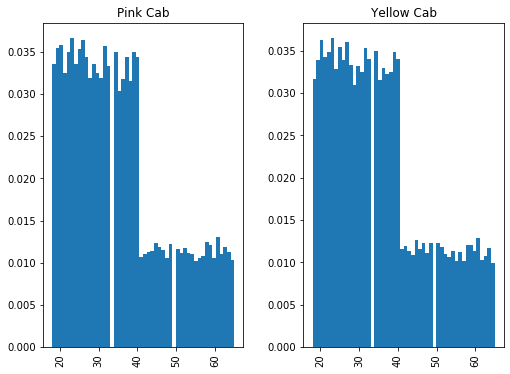

In [76]:
# Plot the distribution of incomes:

hist = Main_df2.hist(column='Age',by='Company',bins=50,figsize=(8,6),density=True)


In [77]:
CompAge = Main_df2[['Company','Age']].sort_values(by=['Company'])
CompAge['Company'].value_counts()

Yellow Cab    274681
Pink Cab       84711
Name: Company, dtype: int64

In [78]:
PinkAge = CompAge[:84711]
PinkAge
YellowAge = CompAge[84711:]
YellowAge

,Company,Age
262806,Yellow Cab,65
262805,Yellow Cab,25
262823,Yellow Cab,33
262824,Yellow Cab,47
262825,Yellow Cab,31
...,...,...
46517,Yellow Cab,27
46518,Yellow Cab,49
46519,Yellow Cab,49
46513,Yellow Cab,33


In [79]:
PinkAge['Age'].values
stats.ks_2samp(PinkAge['Age'].values, YellowAge['Age'].values)

Ks_2sampResult(statistic=0.004093997895440238, pvalue=0.22794103720465184)

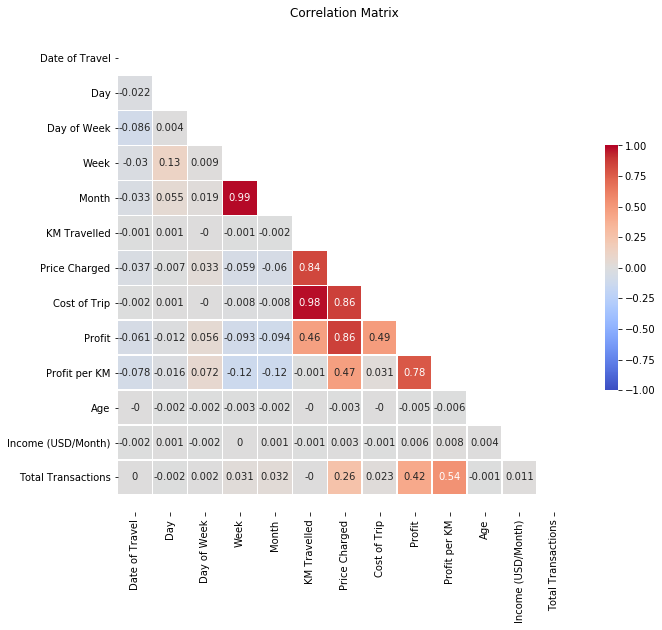

In [121]:
df_corr = Main_df2[['Date of Travel','Day','Day of Week','Week','Month','KM Travelled','Price Charged','Cost of Trip','Profit',
                    'Profit per KM','Age','Income (USD/Month)','Total Transactions']].corr()

df_corr=round(df_corr,3)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(250, 20, as_cmap=True)

plt.title('Correlation Matrix')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr,mask=mask, cmap='coolwarm',annot=True ,vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [131]:
def plot_correlations(param1,param2):
    grouped = Main_df2[['Company',param1,param2]].groupby(['Company'])
    group1 = grouped.get_group('Yellow Cab')
    group2 = grouped.get_group('Pink Cab')
    plt.figure(figsize=(10,8))
    plt.title(f'{param1} vs {param2}')
    plt.scatter(group1[param1],group1[param2],s=1,c='tab:olive',label='Yellow Cab')
    plt.scatter(group2[param1],group2[param2],s=1,c='tab:pink',label='Pink Cab')
    plt.xlabel(param1)
    plt.ylabel(param2)
    # plt.ylim([0,750])
    plt.legend()
    plt.show()

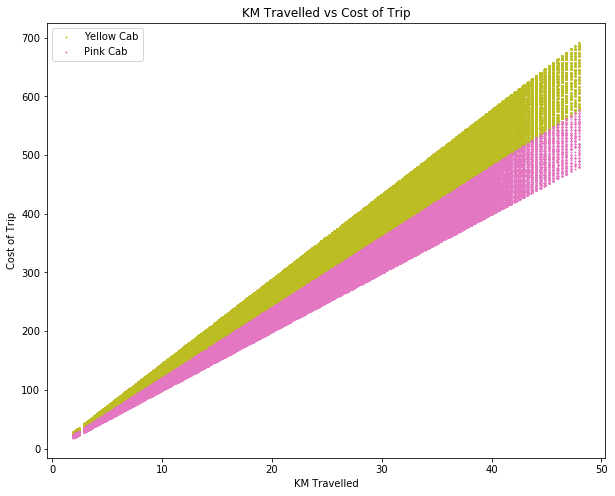

In [132]:
plot_correlations('KM Travelled','Cost of Trip')

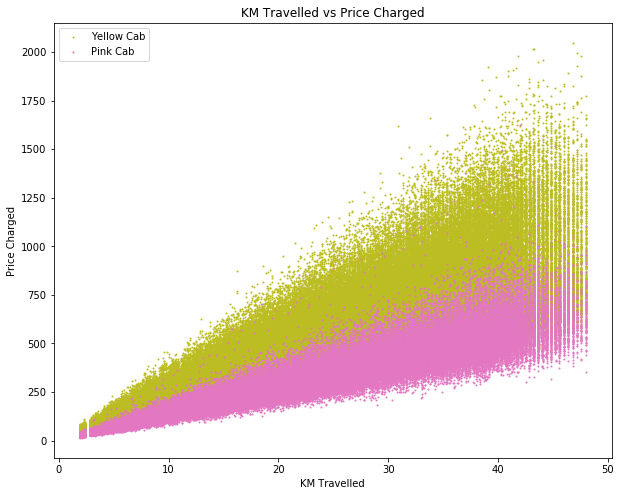

In [133]:
plot_correlations('KM Travelled','Price Charged')

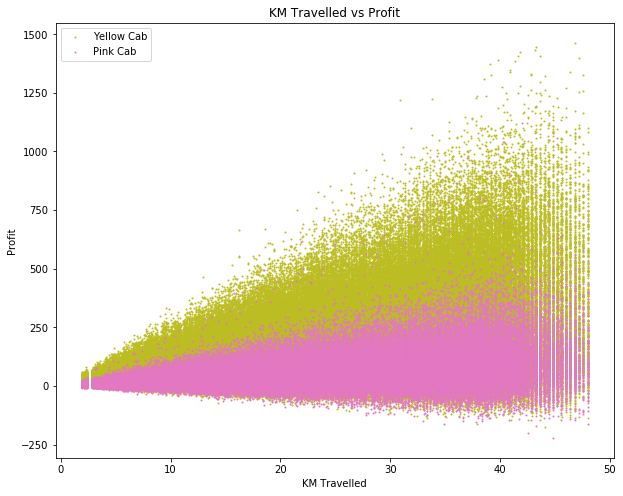

In [134]:
plot_correlations('KM Travelled','Profit')